In [1]:
import sd4py
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from textwrap import wrap
import datetime
import networkx as nx

In [2]:
df2 = pd.DataFrame(
    {
        "A": pd.Series(np.random.randn(1000), dtype="float16"),
        "B": pd.Series(np.random.randn(1000)),
        "C": pd.Series(np.array(np.random.randint(0, 255, 1000, dtype="uint8"))),
        "D": np.random.choice(["foo","bar"], 1000),
        "E": pd.date_range("2018-01-01", periods=1000, freq="H"),
        "G": np.random.choice([1,5,10], 1000),
        "H": [pd.Timedelta(hours=x) for x in np.random.choice(np.arange(1,10),1000)],
        "I": np.random.choice([True,False], 1000),
        "J": np.random.choice(["A", "B", "C", "D", "E", "F"], 1000),
        "K": np.random.choice([True,False], 1000),
        "L": np.random.choice([True,False], 1000),
    }
)

In [3]:
df2.head()

,A,B,C,D,E,G,H,I,J,K,L
0,-0.563477,-0.152587,200,foo,2018-01-01 00:00:00,5,0 days 07:00:00,False,A,False,True
1,1.207031,-0.422163,123,bar,2018-01-01 01:00:00,1,0 days 03:00:00,False,B,False,False
2,-1.002930,0.030698,245,bar,2018-01-01 02:00:00,5,0 days 05:00:00,False,E,False,False
3,-0.860352,0.676332,69,foo,2018-01-01 03:00:00,5,0 days 03:00:00,True,D,True,False
4,-0.185791,0.356831,93,foo,2018-01-01 04:00:00,5,0 days 01:00:00,True,A,True,False


In [4]:
df2.describe()

,A,B,C,G,H
count,1000.000000,1000.000000,1000.000000,1000.000000,1000
mean,-0.020203,-0.040248,126.829000,5.121000,0 days 05:01:55.200000
std,0.990234,0.974587,74.543736,3.613782,0 days 02:36:56.472742960
min,-3.384766,-3.358057,0.000000,1.000000,0 days 01:00:00
25%,-0.669189,-0.689557,62.000000,1.000000,0 days 03:00:00
50%,-0.006886,-0.012401,124.500000,5.000000,0 days 05:00:00
75%,0.616821,0.569765,192.000000,10.000000,0 days 07:00:00
max,3.052734,3.132294,254.000000,10.000000,0 days 09:00:00


In [5]:
subgroups = sd4py.discover_subgroups(df2, "A")

SDMapNum
Time - took: 117 ms. (96 ms. CPU time)
Steps: 982


In [6]:
subgroups.to_df()

,pattern,target_quantity,size,quality
0,J = C,0.125594,168.0,24.494204
1,L = True AND D = bar,0.075317,243.0,23.211689
2,0 days 03:40:00 <= H < 0 days 06:20:00 AND 4.0...,0.150983,120.0,20.542527
3,B < -1.19,0.158233,114.0,20.341897
4,0 days 03:40:00 <= H < 0 days 06:20:00 AND K =...,0.108283,156.0,20.044079
5,J = B AND 2018-01-14 21:00:00 <= E < 2018-01-2...,0.351973,53.0,19.725452
6,84.67 <= C < 169.33 AND L = True AND D = bar,0.247295,71.0,18.992497
7,84.67 <= C < 169.33,0.040789,311.0,18.968947
8,84.67 <= C < 169.33 AND D = bar,0.104557,152.0,18.963822
9,2018-01-14 21:00:00 <= E < 2018-01-28 18:00:00...,0.091011,170.0,18.906672


In [7]:
## Things to do (functions over a PySubgroupResults or an individual PySubgroup):
##    Monte Carlo confidence interval estimation (with option of k-fold method instead)
##    Most interesting numeric columns by effect size
##    Most interesting nominal columns by effect size
##    Then we can visualise

In [8]:
## Okay, so following https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4426159/
## We can compute the values for some number of MC simulations and then take the 0.05 and 0.95 quantiles as confidence intervals 

In [9]:
def monte_carlo_inner(subgroup, samples, target, metric_function):
    
    metric_values = []
    
    for sample in samples:
        
        subgroup_sample = subgroup.get_rows(sample)

        metric_values.append(metric_function(sample, subgroup_sample, target))
                    
    return metric_values
        

In [10]:
def monte_carlo(subgroups, data, target, metric_function, aggregation_function=None, value=None, ignore_defaults=False, number_simulations=100, frac=1/3, replace=True):
    
    samples = []
    
    for x in range(number_simulations):
        
        sample = data.sample(frac=frac, replace=False)
        
        if replace:
            sample = sample.sample(frac=1, replace=True)
            
        if ignore_defaults:
            sample = sample.replace(data.iloc[0,:], np.NaN)
            
        samples.append(sample.reset_index(drop=True))
    
    if isinstance(subgroups, sd4py.PySubgroupResults):
        
        subgroups = subgroups.subgroups
    
    if isinstance(subgroups, list):
        
        out = {}
        
        for subgroup in subgroups:
            
            subgroup_values = monte_carlo_inner(subgroup, samples, target, metric_function)
            
            if aggregation_function is None:
            
                out[str(subgroup)] = subgroup_values
            
            else:
                
                out[str(subgroup)] = aggregation_function(subgroup_values)
        
        return out
    
    else:
        
        if aggregation_function is None:

            return monte_carlo_inner(subgroups, samples, target, metric_function)

        else:

            return aggregation_function(monte_carlo_inner(subgroups, samples, target, metric_function))

In [11]:
def confidence_intervals(subgroups, data, target, value=None, ignore_defaults=False, number_simulations=100, frac=1/3, replace=True):
    
    if data.loc[:,target].dtype == 'object' or data.loc[:,target].dtype == 'bool' or data.loc[:,target].dtype.name == 'category':
            
        if value is None:

            raise ValueError("Target value must be supplied for nominal target.")
            
        def metric_function(sample, subgroup_sample, target):
            
            subgroup_sample = subgroup_sample.loc[:,target]
            sample = sample.loc[:,target]
            
            population_share = subgroup_sample.count() / sample.count()
            target_proportion = subgroup_sample.eq(value).sum() / subgroup_sample.count()
            
            return population_share, target_proportion
        
    else:
        
        def metric_function(sample, subgroup_sample, target):
            
            subgroup_sample = subgroup_sample.loc[:,target]
            sample = sample.loc[:,target]
            
            population_share = subgroup_sample.count() / sample.count()
            average = subgroup_sample.mean()
            
            return population_share, average
        
    def aggregation_function(subgroup_values):
        
        out = {
            'proportion_lower': np.nanquantile([val[0] for val in subgroup_values], 0.05),
            'proportion_upper': np.nanquantile([val[0] for val in subgroup_values], 0.95),
            'target_lower': np.nanquantile([val[1] for val in subgroup_values], 0.05),
            'target_upper': np.nanquantile([val[1] for val in subgroup_values], 0.95)
        }
        
        return out 
    
    results_dict = monte_carlo(subgroups, data, target, metric_function, aggregation_function, value=value, 
                ignore_defaults=ignore_defaults, number_simulations=number_simulations, frac=frac, replace=replace)
    
    return pd.DataFrame({'pattern':str(subgroup), **values} for subgroup, values in results_dict.items())
    

In [12]:
subgroups.to_df().merge(confidence_intervals(subgroups, df2, "A", number_simulations=100), on="pattern")

,pattern,target_quantity,size,quality,proportion_lower,proportion_upper,target_lower,target_upper
0,J = C,0.125594,168.0,24.494204,0.125826,0.216366,-0.170294,0.401172
1,L = True AND D = bar,0.075317,243.0,23.211689,0.198048,0.291441,-0.156793,0.241290
2,0 days 03:40:00 <= H < 0 days 06:20:00 AND 4.0...,0.150983,120.0,20.542527,0.084084,0.156156,-0.127496,0.413245
3,B < -1.19,0.158233,114.0,20.341897,0.080931,0.153153,-0.208112,0.476038
4,0 days 03:40:00 <= H < 0 days 06:20:00 AND K =...,0.108283,156.0,20.044079,0.117117,0.192342,-0.180359,0.367334
5,J = B AND 2018-01-14 21:00:00 <= E < 2018-01-2...,0.351973,53.0,19.725452,0.027027,0.075375,-0.089047,0.781274
6,84.67 <= C < 169.33 AND L = True AND D = bar,0.247295,71.0,18.992497,0.044745,0.099249,-0.097275,0.572046
7,84.67 <= C < 169.33,0.040789,311.0,18.968947,0.269970,0.366366,-0.196185,0.269971
8,84.67 <= C < 169.33 AND D = bar,0.104557,152.0,18.963822,0.120120,0.189489,-0.189264,0.367725
9,2018-01-14 21:00:00 <= E < 2018-01-28 18:00:00...,0.091011,170.0,18.906672,0.126126,0.207207,-0.183618,0.358167


In [13]:
def share_and_average(sample, subgroup_sample, target):

    subgroup_sample = subgroup_sample.loc[:,target]
    sample = sample.loc[:,target]

    population_share = subgroup_sample.count() / sample.count()
    average = subgroup_sample.mean()

    return population_share, average


In [14]:
results_dict = monte_carlo(subgroups, df2, "A", share_and_average)

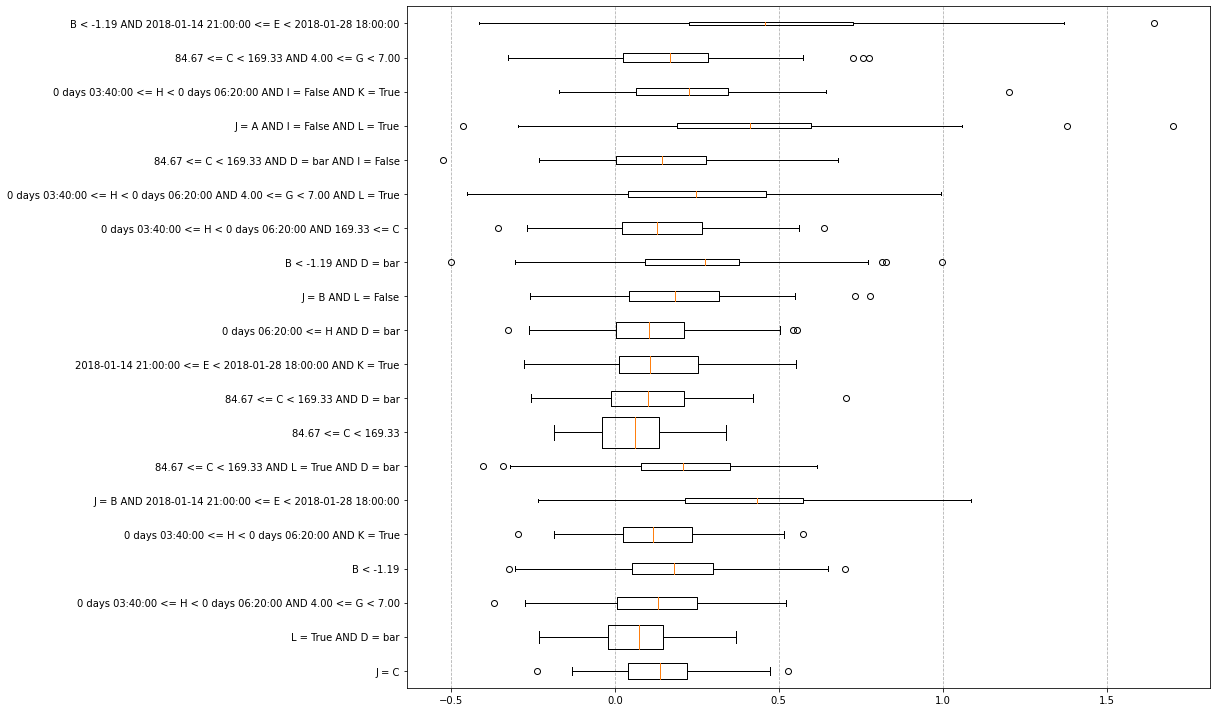

In [44]:
averages = np.stack([np.array(x)[:,1] for x in results_dict.values()])
widths = [np.array(x)[:,0].mean() for x in results_dict.values()]
widths = 0.9 * np.array(widths) / np.max(widths)

plt.boxplot(averages.T, vert=False, widths=widths, labels=results_dict.keys())
plt.gca().xaxis.grid(True, linestyle='--')
plt.gcf().set_size_inches(17,10)
plt.gcf().tight_layout()
plt.savefig('Paper_Figure_1.png', dpi=200)

In [17]:
adjacency = np.zeros((len(subgroups.subgroups), len(subgroups.subgroups)))

for idx1, subgroup1 in enumerate(subgroups.subgroups):
    
    for idx2, subgroup2 in enumerate(subgroups.subgroups):
        
        if idx1 < idx2:
            
            indices1 = subgroup1.get_indices(df2)
            indices2 = subgroup2.get_indices(df2)
            
            adjacency[idx1, idx2] = indices1.intersection(indices2).size / indices1.union(indices2).size

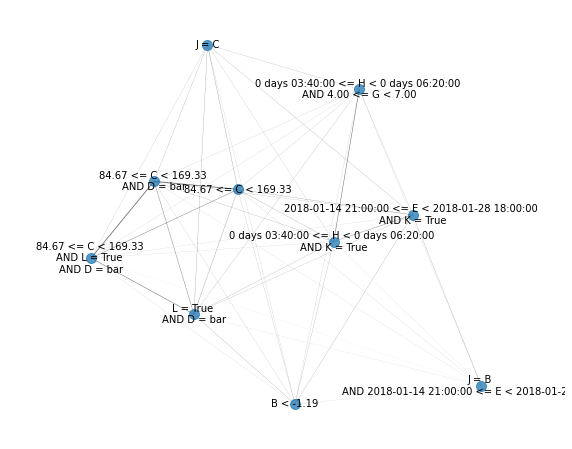

In [42]:
G = nx.from_numpy_matrix(adjacency[:10,:10])

G = nx.relabel_nodes(G, mapping={idx:re.sub('AND', '\nAND', str(sg)) for idx, sg in enumerate(subgroups.subgroups)})

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=100, alpha=0.75)

# edges
nx.draw_networkx_edges(
    G, pos, alpha=0.5,
    width = [2 * x for x in nx.get_edge_attributes(G,'weight').values()]
)

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.gcf().set_size_inches(10,8)
plt.margins(x=0.15)
plt.gca().set_frame_on(False)

plt.savefig('Paper_Figure_2.png', dpi=200)

In [20]:
## Next let's go for precision, recall and F1 for nominal targets, and Hedge's G for numerics

In [21]:
def confidence_precision_recall_f1(subgroups, data, target, value=None, ignore_defaults=False, number_simulations=100, frac=1/3, replace=True):
    
    def metric_function(sample, subgroup_sample, target):

        subgroup_sample = subgroup_sample.loc[:,target]
        sample = sample.loc[:,target]

        precision = subgroup_sample.eq(value).sum() / subgroup_sample.count()
        recall = subgroup_sample.eq(value).sum() / sample.eq(value).sum()
        f1 = (2 * precision * recall) / (precision + recall)

        return precision, recall, f1
    
    def aggregation_function(subgroup_values):
        
        out = {
            'precision_lower': np.nanquantile([val[0] for val in subgroup_values], 0.05),
            'precision_upper': np.nanquantile([val[0] for val in subgroup_values], 0.95),
            'recall_lower': np.nanquantile([val[1] for val in subgroup_values], 0.05),
            'recall_upper': np.nanquantile([val[1] for val in subgroup_values], 0.95),
            'f1_lower': np.nanquantile([val[2] for val in subgroup_values], 0.05),
            'f1_upper': np.nanquantile([val[2] for val in subgroup_values], 0.95)
        }
        
        return out 
    
    results_dict = monte_carlo(subgroups, data, target, metric_function, aggregation_function, value=value, 
                ignore_defaults=ignore_defaults, number_simulations=number_simulations, frac=frac, replace=replace)
    
    return pd.DataFrame({'pattern':str(subgroup), **values} for subgroup, values in results_dict.items())

In [22]:
subgroups = sd4py.discover_subgroups(df2, "J")

In [23]:
subgroups.to_df()

,pattern,target_quantity,size,quality
0,K = True,0.211881,505.0,16.605
1,K = True AND -1.19 <= B < 0.97,0.221918,365.0,15.665
2,E < 2018-01-14 21:00:00 AND L = True AND K = True,0.378378,74.0,14.754
3,E < 2018-01-14 21:00:00 AND K = True,0.263158,171.0,14.391
4,L = True AND K = True,0.237069,232.0,13.472
5,E < 2018-01-14 21:00:00 AND L = True,0.263158,152.0,12.792
6,L = True AND K = True AND -1.19 <= B < 0.97,0.254545,165.0,12.465
7,E < 2018-01-14 21:00:00,0.216216,333.0,12.393
8,E < 2018-01-14 21:00:00 AND D = foo,0.256250,160.0,12.360
9,E < 2018-01-14 21:00:00 AND D = foo AND -1.19 ...,0.275000,120.0,11.520


In [24]:
subgroups.to_df().merge(confidence_precision_recall_f1(subgroups, df2, "J", value="A", number_simulations=100), on="pattern")

/tmp/ipykernel_9775/4188066416.py:10: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (2 * precision * recall) / (precision + recall)


,pattern,target_quantity,size,quality,precision_lower,precision_upper,recall_lower,recall_upper,f1_lower,f1_upper
0,K = True,0.211881,505.0,16.605,0.141820,0.255540,0.425442,0.688792,0.214707,0.369568
1,K = True AND -1.19 <= B < 0.97,0.221918,365.0,15.665,0.139822,0.290979,0.311787,0.604020,0.192491,0.372712
2,E < 2018-01-14 21:00:00 AND L = True AND K = True,0.378378,74.0,14.754,0.183990,0.546307,0.061458,0.285974,0.096387,0.364059
3,E < 2018-01-14 21:00:00 AND K = True,0.263158,171.0,14.391,0.140050,0.377456,0.124890,0.367401,0.136139,0.350213
4,L = True AND K = True,0.237069,232.0,13.472,0.134134,0.333527,0.178483,0.435013,0.167102,0.362066
5,E < 2018-01-14 21:00:00 AND L = True,0.263158,152.0,12.792,0.136996,0.370852,0.110940,0.345726,0.128053,0.336159
6,L = True AND K = True AND -1.19 <= B < 0.97,0.254545,165.0,12.465,0.132619,0.389286,0.104043,0.386478,0.116973,0.387661
7,E < 2018-01-14 21:00:00,0.216216,333.0,12.393,0.121303,0.307724,0.260326,0.536560,0.171684,0.383202
8,E < 2018-01-14 21:00:00 AND D = foo,0.256250,160.0,12.360,0.144934,0.376645,0.136103,0.348359,0.144766,0.344044
9,E < 2018-01-14 21:00:00 AND D = foo AND -1.19 ...,0.275000,120.0,11.520,0.131122,0.405037,0.093692,0.293833,0.109638,0.333667


In [25]:
subgroups = sd4py.discover_subgroups(df2, "A")

SDMapNum
Time - took: 50 ms. (47 ms. CPU time)
Steps: 982


In [26]:
## ref:https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/hedgeg.htm

def corrected_hedges_g(sample1, sample2):
    
    n_1 = sample1.count()
    n_2 = sample2.count()
    
    pooled_sd = np.sqrt((((n_1-1) * sample1.var()) + ((n_2-1) * sample2.var())) / (n_1 + n_2 - 2))
    
    n =  n_1 + n_2
    bias_correction = ((n-3)/(n-2.25)) * np.sqrt((n - 2) / n)
    
    return bias_correction * (sample1.mean() - sample2.mean()) / pooled_sd

In [27]:
def confidence_hedges_g(subgroups, data, target, ignore_defaults=False, number_simulations=100, frac=1/3, replace=True):
    
    def metric_function(sample, subgroup_sample, target):

        subgroup_sample = subgroup_sample.loc[:,target]
        sample = sample.loc[:,target]
        complement = sample[~sample.index.isin(subgroup_sample.index)]

        proportion = subgroup_sample.count() / sample.count()
        hedges_g = corrected_hedges_g(subgroup_sample, complement)

        return proportion, hedges_g
    
    def aggregation_function(subgroup_values):
        
        out = {
            'proportion_lower': np.nanquantile([val[0] for val in subgroup_values], 0.05),
            'proportion_upper': np.nanquantile([val[0] for val in subgroup_values], 0.95),
            'hedges_g_lower': np.nanquantile([val[1] for val in subgroup_values], 0.05),
            'hedges_g_upper': np.nanquantile([val[1] for val in subgroup_values], 0.95)
        }
        
        return out 
    
    results_dict = monte_carlo(subgroups, data, target, metric_function, aggregation_function, 
                ignore_defaults=ignore_defaults, number_simulations=number_simulations, frac=frac, replace=replace)
    
    return pd.DataFrame({'pattern':str(subgroup), **values} for subgroup, values in results_dict.items())

In [28]:
subgroups.to_df().merge(confidence_hedges_g(subgroups, df2, "A", number_simulations=100), on="pattern")

,pattern,target_quantity,size,quality,proportion_lower,proportion_upper,hedges_g_lower,hedges_g_upper
0,J = C,0.125594,168.0,24.494204,0.125976,0.207357,-0.120535,0.428949
1,L = True AND D = bar,0.075317,243.0,23.211689,0.198198,0.297447,-0.125041,0.387254
2,0 days 03:40:00 <= H < 0 days 06:20:00 AND 4.0...,0.150983,120.0,20.542527,0.081081,0.147447,-0.168545,0.604682
3,B < -1.19,0.158233,114.0,20.341897,0.077928,0.156156,-0.138692,0.513906
4,0 days 03:40:00 <= H < 0 days 06:20:00 AND K =...,0.108283,156.0,20.044079,0.119970,0.195345,-0.177183,0.474637
5,J = B AND 2018-01-14 21:00:00 <= E < 2018-01-2...,0.351973,53.0,19.725452,0.033033,0.081231,-0.076697,0.732302
6,84.67 <= C < 169.33 AND L = True AND D = bar,0.247295,71.0,18.992497,0.050901,0.102252,-0.179964,0.650594
7,84.67 <= C < 169.33,0.040789,311.0,18.968947,0.267117,0.363363,-0.212567,0.387133
8,84.67 <= C < 169.33 AND D = bar,0.104557,152.0,18.963822,0.120120,0.195195,-0.228518,0.472643
9,2018-01-14 21:00:00 <= E < 2018-01-28 18:00:00...,0.091011,170.0,18.906672,0.125976,0.216366,-0.146905,0.475983


In [29]:
def odds_ratio_ci(sample1, sample2):
    
    a = sample1.eq(True).sum() # subgroup == True and column == value
    b = sample1.eq(False).sum() # subgroup == True and column != value
    c = sample2.eq(True).sum() # subgroup == False and column == value
    d = sample2.eq(False).sum()  # subgroup == False and column != value
    
    if min(a,b,c,d) == 0:
        
        return np.NaN, np.NaN, np.NaN
    
    odds_ratio = (a * d) / (b * c)
    
    lower = np.exp(np.log(odds_ratio) - (1.96 * np.sqrt((1/a) + (1/b) + (1/c) + (1/d))))
    upper = np.exp(np.log(odds_ratio) + (1.96 * np.sqrt((1/a) + (1/b) + (1/c) + (1/d))))
    
    return odds_ratio, lower, upper

In [30]:
## Remember to use abs() when ranking the features

## Let's just use odds ratio on each combo of variable+value (up to 5 most common values per variable)
## Comme ca:

In [31]:
vals, counts = np.unique(df2.J, return_counts=True)
vals[np.argsort(-counts)][:5]

array(['E', 'A', 'B', 'C', 'D'], dtype=object)

In [32]:
def find_interesting_columns(subgroup, data, use_complement = True, ignore_defaults = False, columns_to_ignore=[]):
    
    numeric_columns = {}
    nominal_columns = {}
    
    subgroup_indices = subgroup.get_indices(data)
        
    if ignore_defaults:

        data = data.replace(data.iloc[0,:], np.NaN)
    
    for column in data:
        
        if column in columns_to_ignore:
            
            continue
        
        column = data[column]
        
        if (np.issubdtype(column.dtype, np.datetime64) or np.issubdtype(column.dtype, np.timedelta64)):
            
            column = pd.to_numeric(column) 
            column = (column - column.mean()) / column.std() ## Just to get to a reasonable timescale, otherwise it's nanoseconds or something like that
        
        subgroup_rows = column.loc[subgroup_indices]

        if use_complement:
            population_rows = column.drop(subgroup_indices, axis=0)
        else:
            population_rows = column
        
        if column.dtype == 'object' or column.dtype == 'bool' or column.dtype.name == 'category':

            vals, counts = np.unique(column, return_counts=True)

            for value in vals[np.argsort(-counts)][:5]: ## 5 most common values
                
                nominal_columns[(column.name, value)] = odds_ratio_ci(subgroup_rows == value, population_rows == value)

        else:
            
            numeric_columns[column.name] = corrected_hedges_g(subgroup_rows, population_rows)

    return numeric_columns, nominal_columns      
                    
            

In [33]:
def most_interesting_columns(subgroup, data, columns_to_ignore=[]):
    
    interesting_numeric, interesting_nominal = find_interesting_columns(subgroup, data, columns_to_ignore=columns_to_ignore)
    
    interesting_numeric = pd.DataFrame(interesting_numeric.values(), index=interesting_numeric.keys())
    interesting_numeric = interesting_numeric.dropna()
    interesting_nominal = pd.DataFrame(interesting_nominal.values(), index=interesting_nominal.keys())
    interesting_nominal = interesting_nominal.dropna()
    
    if len(interesting_numeric):

        interesting_numeric = interesting_numeric.dropna()
        most_interesting_numeric = interesting_numeric.iloc[interesting_numeric[0].abs().argsort()][::-1][0].iloc[:10] ## Find the 10 most interesting by effect size

    else:
        
        most_interesting_numeric = interesting_numeric
    
    if len(interesting_nominal) > 0:
        
        max_lower = interesting_nominal.loc[interesting_nominal[1].abs().groupby(level=0).idxmax()][1] ## Maximum lower confidence interval
        max_lower = max_lower.iloc[max_lower.abs().argsort()][::-1]
        max_lower

        min_upper = interesting_nominal.loc[interesting_nominal[2].abs().groupby(level=0).idxmin()][2]
        min_upper = min_upper[interesting_nominal.groupby(level=0).count()[2].values > 2]
        min_upper = min_upper[min_upper > 0]
        min_upper = (1 / min_upper)
        min_upper = min_upper.iloc[min_upper.abs().argsort()][::-1]
        min_upper

        most_interesting_nominal = pd.concat([max_lower, min_upper]).sort_values(ascending=False).iloc[:10] ## 10 most interesting by having especially high or especially low odds ratio
    
    else:
        
        most_interesting_nominal = interesting_nominal
    
    return most_interesting_numeric, most_interesting_nominal

In [34]:
most_interesting_numeric = most_interesting_columns(subgroups.subgroups[0], df2)[0]

In [35]:
def members_over_time(subgroup, data, window=None, columns_to_ignore=[]):
    
    most_interesting_numeric = most_interesting_columns(subgroup, data, columns_to_ignore)[0]

    for idx, col in enumerate(most_interesting_numeric.index):
        
        if window is not None:
            
            plotting_data = data[col].iloc[:window * (len(data) // window)]
            
            plotting_data = plotting_data.groupby(np.arange(len(plotting_data)) // window).mean(numeric_only=False)
            
            plotting_data = pd.Series(plotting_data.values, index=data.index.values[(np.arange(len(data) // window) * window) + (window//2)], name=col)
        
        else:
            
            plotting_data = data[col]

        ax = plt.subplot(len(most_interesting_numeric),1,idx+1)
        ax.plot(plotting_data)
        ax.annotate(col, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 10, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
        
        if np.issubdtype(data[col].dtype, np.timedelta64):
            
            ax.set_yticks(ax.get_yticks())
            ax.set_yticklabels([str(x) for x in pd.to_timedelta(ax.get_yticks())])

        member_indices = subgroup.get_indices(data)
        
        if window is None:
            
            window_tmp = 1
        
        else:
            
            window_tmp = window
            
        member_counts = []

        for window_values in data.index.values.reshape(-1,window_tmp):

            member_counts.append(np.isin(window_values, member_indices).sum())

        member_counts = pd.Series(member_counts, index=data.index.values[::window_tmp])
        
        for i in range(len(member_counts)):
            
            value = member_counts.iloc[i]
            start = data.index[(i * window_tmp)]
            end = data.index[(i * window_tmp): (i * window_tmp) + window_tmp][-1]
            
            plt.axvspan(xmin=start, xmax=end, color='tab:red', alpha=value/window_tmp)

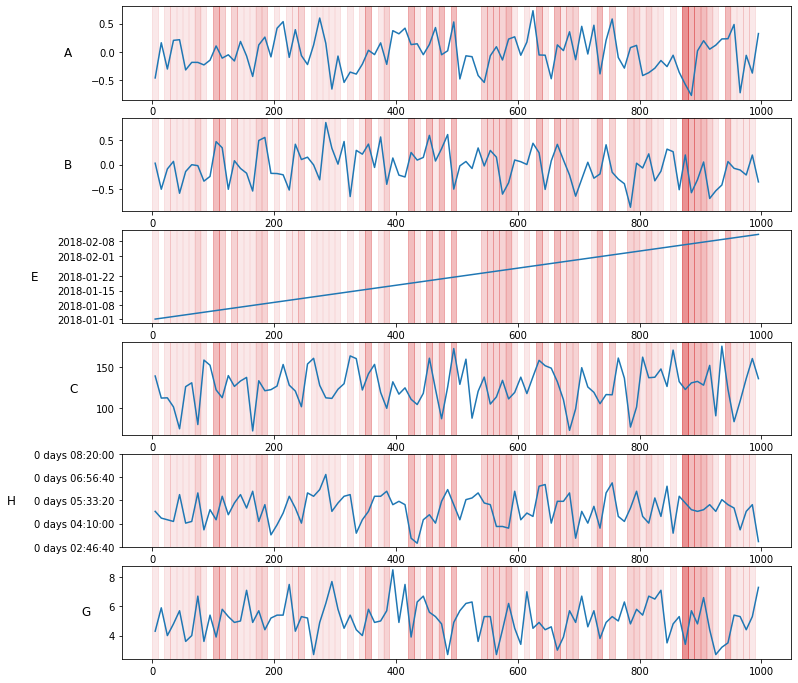

In [36]:
members_over_time(subgroups.subgroups[2], df2, window=10, columns_to_ignore=[])
plt.gcf().set_size_inches(12,12)

plt.savefig('Paper_Figure_4.png', dpi=200)

In [37]:
def radar_plot(data, prop_scale=3, subplot=111, text_size = 10, axis_padding = 15, ymins = None, ymaxes = None):
    
    # Set axis_start_prop to 0 if you want the axes to scale from 0 to the max in the data, or set axis_start_prop to 1 if you want the axes to start from the minimum in the data
    
    N = data.shape[1]
    
    if N < 3:
        
        N = 3
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] # And back to the first position

    # Initialise the spider plot
    ax = plt.subplot(subplot, polar=True)

    # To put the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    plt.xticks(angles[:len(data.columns)], data.columns, size=text_size+1)
    
    ax.spines['polar'].set_color('grey')
    
    ax.yaxis.set_visible(False) # Axes and appropriate scales will be drawn later, using polar_twin
    
    ax.grid(False) # Axes and appropriate scales will be drawn later, using polar_twin
    
    ax.tick_params(axis='x', which='major', pad=axis_padding)          #Space the axis labels a bit
    
    def polar_twin(ax, ymin, ymax, angle=20):
        
        # Make the new axis in order to draw the appropriate scale 
        
        ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                                 label='twin', frameon=False,
                                 theta_direction=ax.get_theta_direction(),
                                 theta_offset=ax.get_theta_offset())
        ax2.xaxis.set_visible(False)
        
        #labels = [ymin, ymax]
        
        labels = [ymin, ymin + ((ymax-ymin) * 1/3), ymin + ((ymax-ymin) * 2/3), ymax]

        if hasattr(ymin, 'strftime'):
            labels = [item.strftime('%Y-%m-%d\n%H:%M:%S') for item in labels]
        else:
            try:
                labels = ["{:.2f}".format(float(item)) for item in labels]

            except:
                labels = ["{0} days\n{1:02d}:{2:02d}:{3:02d}".format(*item.components) for item in labels]

        ax2.set_ylim(0, 1+prop_scale)
        ax2.set_rgrids([1,1+(prop_scale/3),1+(2*prop_scale/3),1+prop_scale], labels, angle, size=text_size, ha="center", va="center")

        # Bit of a hack to ensure that the original axes tick labels are on top of
        # whatever is plotted in the twinned axes. Tick labels will be drawn twice.
        for label in ax.get_yticklabels():
            ax.figure.texts.append(label)
        
        ax2.grid(False)
        
        return ax2
    
    if ymins is None:
        ymins = data.min()

    if ymaxes is None:
        ymaxes = data.max()
    
    for idx, colname in enumerate(data):
        
        col = data.loc[:,colname]
        
        ymin = ymins[colname]
        ymax = ymaxes[colname]
        
        angle = idx * 360 / N
        
        ax_latest = polar_twin(ax, ymin, ymax, angle)
        
        ax_latest.set_zorder(100)  # so axis grid doesn't appear in front of other content
    
    ax_latest.grid(True)
    ax_latest.set_zorder(10)  # so axis grid doesn't appear in front of other content
    
    def plot_polygon(row, angles, colour, label):

        # Draws the polygon for one subgroup onto the radar plot 
        
        values=row.flatten().tolist()
        if len(values) < 3:
            values += np.ones(3 - len(values)).tolist()
        values += values[:1]
        ax.set_ylim(0, 1+prop_scale)
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=colour, label=label)
        ax.fill(angles, values, colour, alpha=0.1)
    
    data_norm = 1 + (prop_scale * (data - ymins) / (ymaxes - ymins))   # Scale the data to match to the labels
    
    for idx, row in enumerate(data_norm.values):
        
        # We use standard 'tableau' colours from matplotlib
        
        plot_polygon(row, angles, list(mcolors.TABLEAU_COLORS)[idx % len(mcolors.TABLEAU_COLORS)], label=str(data_norm.index[idx]))
        
    # Draw a legend now tha the polygons have been plotted
    
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    ax.set_zorder(100)  # so axis grid doesn't appear in front of other content
    ax.patch.set_visible(False)  # so axis grid doesn't appear in front of other content
    
    return ax

In [38]:
def visualise_subgroup(subgroup, target, selection_data, visualisation_data=None, use_complement=True):
    
    if visualisation_data is None:
        
        visualisation_data = selection_data
    
    def visualise_columns(numeric_columns=None, nominal_columns=None, nominal_values=None, prop_scale=2.5, subplot=111):
        
        means = pd.DataFrame()
        proportions = pd.DataFrame()
        numeric_ymins = pd.Series(dtype=object)
        numeric_ymaxes = pd.Series(dtype=object)
        nominal_ymins = pd.Series(dtype=object)
        nominal_ymaxes = pd.Series(dtype=object)
        
        subgroup_indices = subgroup.get_indices(visualisation_data)
        
        ## Numerics
        
        if numeric_columns is not None:

            subgroup_means = visualisation_data.loc[subgroup_indices][numeric_columns].mean(numeric_only=False)

            if use_complement:
                means = pd.concat([
                            subgroup_means, 
                            visualisation_data.drop(subgroup_indices, axis=0)[numeric_columns].mean(numeric_only=False)
                        ], axis=1).T.set_index([['Subgroup', 'Complement']])

            else:
                means = pd.concat([
                            subgroup_means, 
                            visualisation_data[numeric_columns].mean(numeric_only=False)
                        ], axis=1).T.set_index([['Subgroup', 'Population']])

            vis_data_numerics = visualisation_data[numeric_columns]

            numeric_ymins = vis_data_numerics.mean(numeric_only=False) - (vis_data_numerics.std(numeric_only=False))

            numeric_ymins = pd.concat([
                numeric_ymins,
                subgroup_means
            ],axis=1).T.min(numeric_only=False)

            numeric_ymaxes = vis_data_numerics.mean(numeric_only=False) + (vis_data_numerics.std(numeric_only=False))

            numeric_ymaxes = pd.concat([
                numeric_ymaxes,
                subgroup_means
            ],axis=1).T.max(numeric_only=False)

        ## Now the nominals
        
        if nominal_columns is not None:
            
            nominal_data = visualisation_data.loc[:,nominal_columns].astype(str)

            subgroup_proportions = nominal_data.loc[subgroup_indices, :].eq(nominal_values).sum() \
                                / nominal_data.loc[subgroup_indices, :].count()
            
            if use_complement:

                proportions = pd.concat([
                            subgroup_proportions, 
                            nominal_data.drop(subgroup_indices, axis=0).eq(nominal_values).sum() \
                                / nominal_data.drop(subgroup_indices, axis=0).count()
                        ], axis=1).T.set_index([['Subgroup', 'Complement']])

            else:

                proportions = pd.concat([
                            subgroup_proportions, 
                            nominal_data.eq(nominal_values).sum() \
                                / nominal_data.count()
                        ], axis=1).T.set_index([['Subgroup', 'Population']])

            nominal_ymins = ((2* proportions) - 1).min()
            nominal_ymins = pd.concat([nominal_ymins, pd.Series(0, index=nominal_ymins.index)], axis=1).T.max()

            nominal_ymaxes = (2* proportions).max()
            nominal_ymaxes = pd.concat([nominal_ymaxes, pd.Series(1, index=nominal_ymaxes.index)], axis=1).T.min()

            nominal_ymins.index = ["{0} == {1}".format(*x) for x in zip(nominal_columns, nominal_values)]
            nominal_ymaxes.index = ["{0} == {1}".format(*x) for x in zip(nominal_columns, nominal_values)]
            proportions.columns = ["{0} == {1}".format(*x) for x in zip(nominal_columns, nominal_values)]

        total = pd.concat([means, proportions], axis=1)
        ymins = pd.concat([numeric_ymins, nominal_ymins])
        ymaxes = pd.concat([numeric_ymaxes, nominal_ymaxes])
        
        radar_plot(total, prop_scale=prop_scale, ymins=ymins, ymaxes=ymaxes, subplot=subplot)
        
    ## Target
    
    ax = plt.subplot(221)
    subgroup_indices = subgroup.get_indices(visualisation_data)
    
    if visualisation_data[target].dtype == 'object' or visualisation_data[target].dtype == 'bool' or visualisation_data[target].dtype.name == 'category':

        if use_complement:
            pd.concat([
                pd.Series(*np.unique(visualisation_data.loc[subgroup_indices][target], return_counts=True)[::-1], name='Subgroup') \
                                / visualisation_data.loc[subgroup_indices][target].count(),
                pd.Series(*np.unique(visualisation_data.drop(subgroup_indices, axis=0)[target], return_counts=True)[::-1], name='Complement') \
                                / visualisation_data.drop(subgroup_indices, axis=0)[target].count()
            ],axis=1).T.plot(kind='barh', stacked=True, cmap=plt.get_cmap('Set2'), ax=ax)
                        
            for container in ax.containers:
                ax.bar_label(container, label_type='center', fmt="%.2f")
            ax.legend()
        
        else:
            pd.concat([
                pd.Series(*np.unique(visualisation_data.loc[subgroup_indices][target], return_counts=True)[::-1], name='Subgroup') \
                                / visualisation_data.loc[subgroup_indices][target].count(),
                pd.Series(*np.unique(visualisation_data[target], return_counts=True)[::-1], name='Complement') \
                                / visualisation_data[target].count()
            ],axis=1).T.plot(kind='barh', stacked=True, cmap=plt.get_cmap('Set2'), ax=ax)   
            
    else:
        
        if use_complement:
            sns.kdeplot(visualisation_data.loc[subgroup_indices][target], linewidth=2, label='Subgroup')
            sns.kdeplot(visualisation_data.drop(subgroup_indices, axis=0)[target], linewidth=2, label='Complement')
        
        else:
            sns.kdeplot(visualisation_data.loc[subgroup_indices][target], linewidth=2, label='Subgroup')
            sns.kdeplot(visualisation_data[target], linewidth=2, label='Population')
            ax.legend()
    
    ## Selectors
    
    numeric_selectors = []
    nominal_selectors = []
    nominal_selector_values = []
    
    for selector in subgroup.selectors:
        
        if isinstance(selector, sd4py.PyNumericSelector):
            
            numeric_selectors.append(selector.attribute)
        
        else:
            
            nominal_selectors.append(selector.attribute)
            nominal_selector_values.append(str(selector.value))
    
    if len(numeric_selectors) == 0:
        numeric_selectors = None
    
    if len(nominal_selectors) == 0:
        nominal_selectors = None
    
    visualise_columns(numeric_columns=numeric_selectors, nominal_columns=nominal_selectors, nominal_values=nominal_selector_values, subplot=222)
    
    
    ## Additional variables
    columns_to_ignore = [s.attribute for s in subgroup.selectors] ## Selectors will already be visualised
    columns_to_ignore += [target] ## Target will already be visualised
    
    most_interesting_numeric, most_interesting_nominal = most_interesting_columns(subgroup, selection_data, columns_to_ignore=columns_to_ignore)
    
    ## Numeric
    
    if len(most_interesting_numeric) > 0:
        
        visualise_columns(numeric_columns=most_interesting_numeric.index.tolist(), subplot=223)
    
    ## Nominals
    
    if len(most_interesting_nominal) > 0:
    
        columns = [x[0] for x in most_interesting_nominal.index]
        values = [str(x[1]) for x in most_interesting_nominal.index]

        visualise_columns(nominal_columns=columns, nominal_values=values, subplot=224)


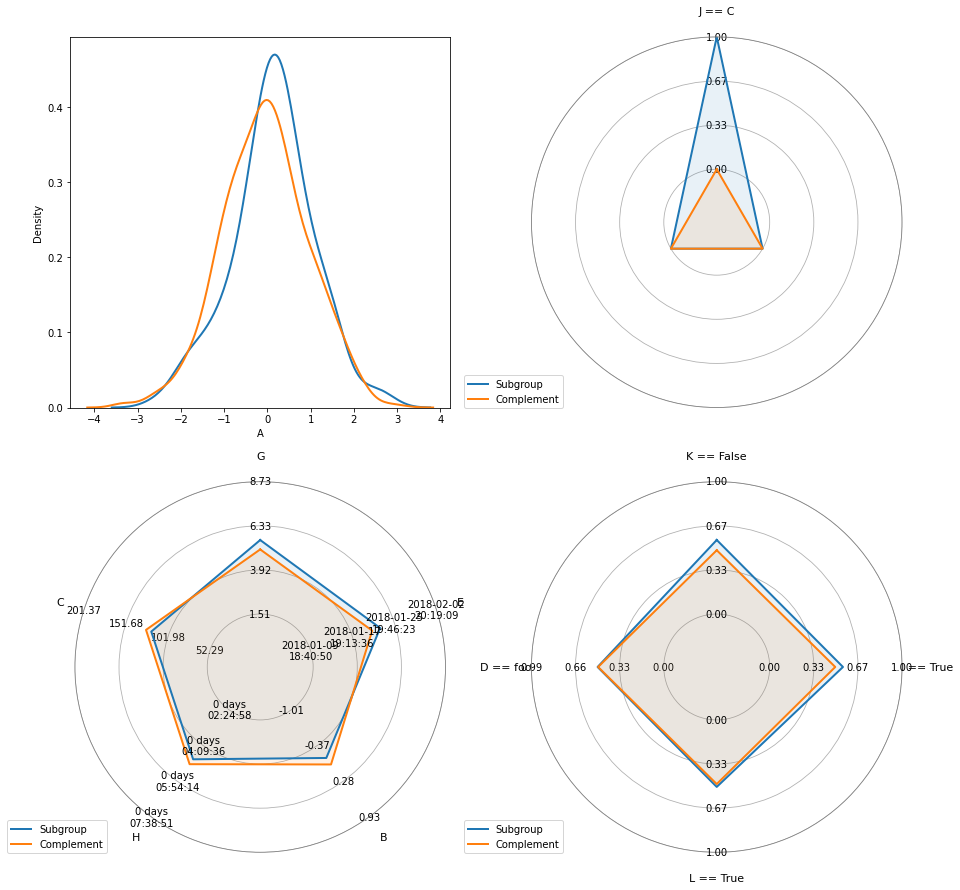

In [39]:
plt.rcParams["figure.figsize"] = (15,15)
visualise_subgroup(subgroups.subgroups[0], 'A', df2, df2)

plt.savefig('Paper_Figure_3.png', dpi=200)

In [40]:
## Next

## Add titles to the quadrants
## Fix text size and wrapping and emphasis

## More testing